In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

In [3]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [4]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [5]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


In [6]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

In [7]:
df_trn_denorm.isna().sum()

create_dt_transaction       0
content_id                  0
acct_id                     0
price                       0
device_id                   0
device_name                 0
create_dt_acct           2742
payment_type             2742
dtype: int64

In [8]:
# fill accounts that cannot join to payment_type
df_trn_denorm['payment_type'] = df_trn_denorm['payment_type'].fillna('unknown')

In [10]:
# 25 account_ids without payment_type
df_trn_denorm[['payment_type', 'acct_id']].groupby(by=['payment_type']).nunique()

,acct_id
payment_type,
Free only,14993
PMOF,14982
unknown,25


In [11]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

In [12]:
# unknown payment types account for a small subset of transactions
df_wide[['payment_type', 'content_id']].groupby(by=['payment_type']).count()

,content_id
payment_type,
Free only,1167271
PMOF,2437496
unknown,2742


In [13]:
# unknown payment types account for a small subset of transactions
df_wide[['payment_type', 'price']].groupby(by=['payment_type']).sum()

,price
payment_type,
Free only,0.00
PMOF,19037307.25
unknown,12184.60


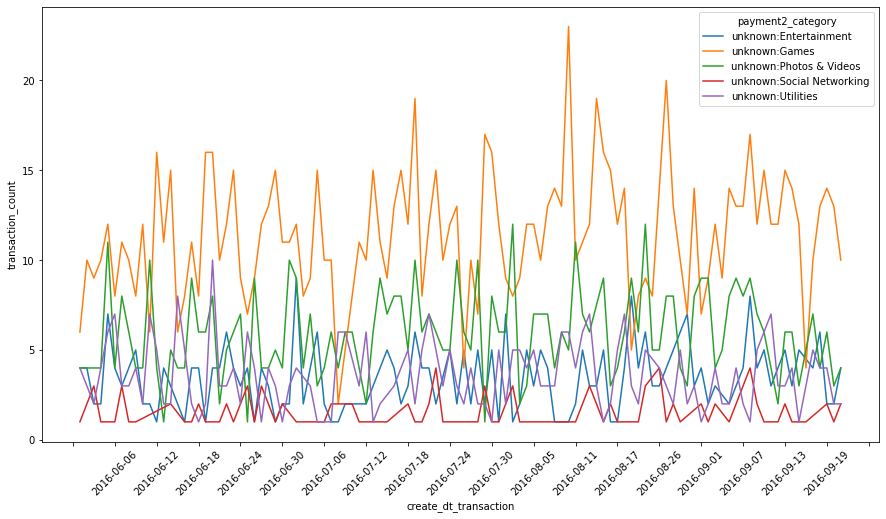

In [14]:
# visually, no changes in transaction count over time for unknown payment types
df_wide['payment2_category'] = df_wide['payment_type'] + ':' + df_wide['category_name']

df_wide_sub5 = df_wide[df_wide['payment_type'] == 'unknown']

df_wide5 = df_wide_sub5[['create_dt_transaction', 'payment2_category', 'price']]\
.groupby(by=['create_dt_transaction', 'payment2_category'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='payment2_category', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

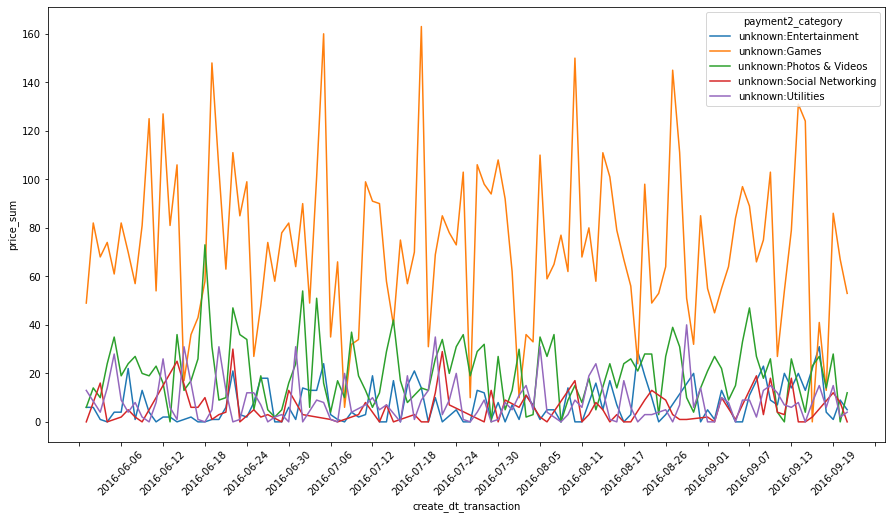

In [16]:
# visually, no changes in sum prices count over time for unknown payment types
df_wide['payment2_category'] = df_wide['payment_type'] + ':' + df_wide['category_name']

df_wide_sub5 = df_wide[df_wide['payment_type'] == 'unknown']

df_wide5 = df_wide_sub5[['create_dt_transaction', 'payment2_category', 'price']]\
.groupby(by=['create_dt_transaction', 'payment2_category'], as_index=False).sum()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='payment2_category', 
             data=df_wide5)
ax.set_ylabel('price_sum')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

### Investigate PMOF accounts with free game downloads

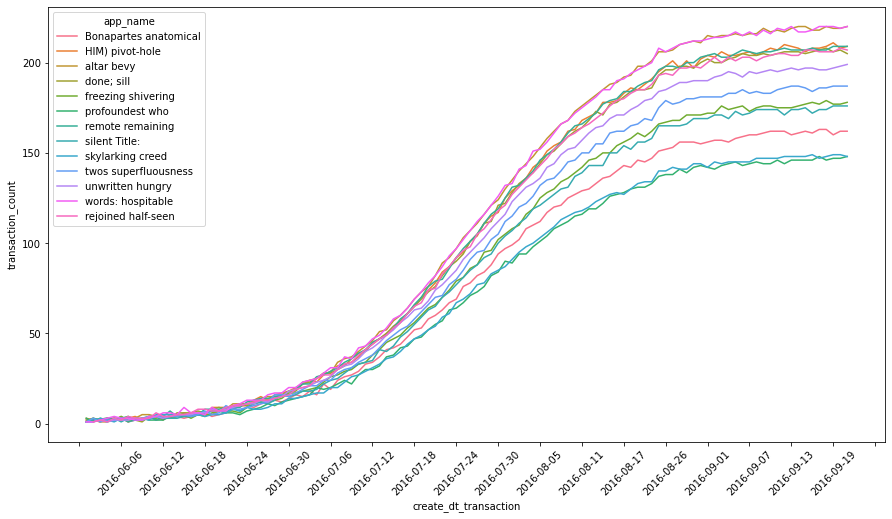

In [17]:
# free game app download

df_wide_sub5 = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'price']]\
.groupby(by=['create_dt_transaction', 'app_name'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

In [19]:
df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]['acct_id'].unique()

array(['fe74807487952ae6', '0697cfc8d4d6e72b', '3a77f468533d8813', ...,
       '2d75018f29283e30', '5ba56a6aa6faffa2', '90481d05ff841878'],
      dtype=object)

In [22]:
pd.set_option('display.max_rows', 500)

In [24]:
# only one download per account over time. no unistalls and redownloads
df_wide[(df_wide['acct_id'] == 'fe74807487952ae6') &
       (df_wide['price'] == 0)].sort_values(by='create_dt_transaction')

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment2_category
2920894,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.0,2,iPad,3/7/10,PMOF,unwritten hungry,download_only,Games,PMOF:Games
2951659,2016-06-14,e23a29e2bf759dec,fe74807487952ae6,0.0,2,iPad,3/7/10,PMOF,rejoined half-seen,download_only,Games,PMOF:Games
2963598,2016-07-16,d97771dfca471b80,fe74807487952ae6,0.0,2,iPad,3/7/10,PMOF,altar bevy,download_only,Games,PMOF:Games
2998517,2016-08-06,a79e0d352f7fa8bc,fe74807487952ae6,0.0,2,iPad,3/7/10,PMOF,remote remaining,download_only,Games,PMOF:Games
2988763,2016-08-16,c31b6ffb3bc47d7f,fe74807487952ae6,0.0,1,iPhone,3/7/10,PMOF,HIM) pivot-hole,download_only,Games,PMOF:Games
2980831,2016-09-02,8a17af073d2b213a,fe74807487952ae6,0.0,1,iPhone,3/7/10,PMOF,silent Title:,download_only,Games,PMOF:Games
3035207,2016-09-10,0ff4f915b86bcc05,fe74807487952ae6,0.0,1,iPhone,3/7/10,PMOF,Bonapartes anatomical,download_only,Games,PMOF:Games
3027404,2016-09-17,4046c4e9ca784288,fe74807487952ae6,0.0,1,iPhone,3/7/10,PMOF,done; sill,download_only,Games,PMOF:Games
2943011,2016-09-19,d9ac236641bd3859,fe74807487952ae6,0.0,1,iPhone,3/7/10,PMOF,words: hospitable,download_only,Games,PMOF:Games


In [25]:
df_wide[(df_wide['acct_id'] == '5ba56a6aa6faffa2') &
       (df_wide['price'] == 0)].sort_values(by='create_dt_transaction')

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment2_category
3021823,2016-08-17,4046c4e9ca784288,5ba56a6aa6faffa2,0.0,1,iPhone,6/10/09,PMOF,done; sill,download_only,Games,PMOF:Games
3000896,2016-08-20,a79e0d352f7fa8bc,5ba56a6aa6faffa2,0.0,2,iPad,6/10/09,PMOF,remote remaining,download_only,Games,PMOF:Games
3033376,2016-08-29,0ff4f915b86bcc05,5ba56a6aa6faffa2,0.0,1,iPhone,6/10/09,PMOF,Bonapartes anatomical,download_only,Games,PMOF:Games
3053190,2016-09-11,0ceab364ddb9372d,5ba56a6aa6faffa2,0.0,1,iPhone,6/10/09,PMOF,profoundest who,download_only,Games,PMOF:Games
2994741,2016-09-18,c31b6ffb3bc47d7f,5ba56a6aa6faffa2,0.0,1,iPhone,6/10/09,PMOF,HIM) pivot-hole,download_only,Games,PMOF:Games


In [29]:
df_wide5.set_index('create_dt_transaction', inplace=True)

In [37]:
df_wide5_cumsum = df_wide5.cumsum().reset_index()

In [40]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='app_name', 
             data=df_wide5_cumsum)
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

Error in callback <function flush_figures at 0x7fad1843e040> (for post_execute):


KeyboardInterrupt: 

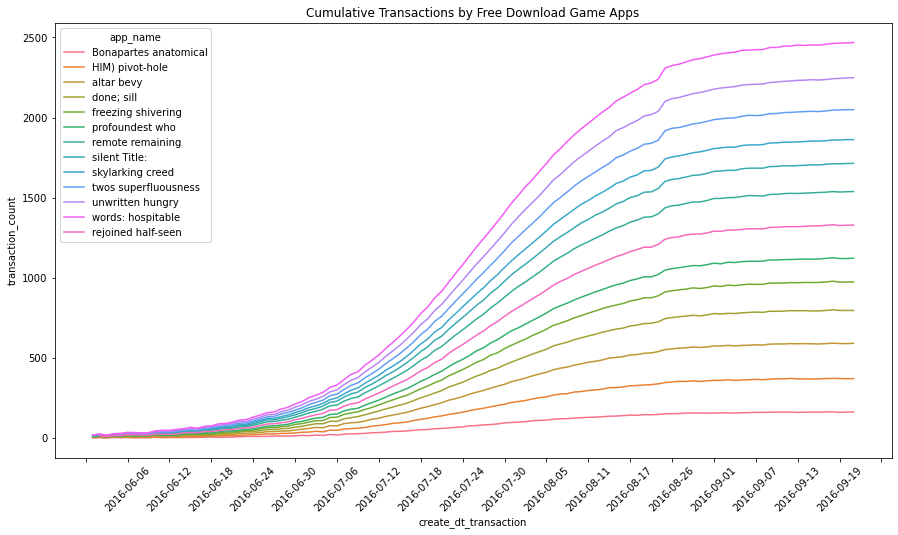

In [58]:
# cumulative sum of transactions by app_name
df_wide_sub5 = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'price']]\
.groupby(by=['create_dt_transaction', 'app_name']).count()\
.groupby(level=0).cumsum().reset_index()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.set_title('Cumulative Transactions by Free Download Game Apps')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))


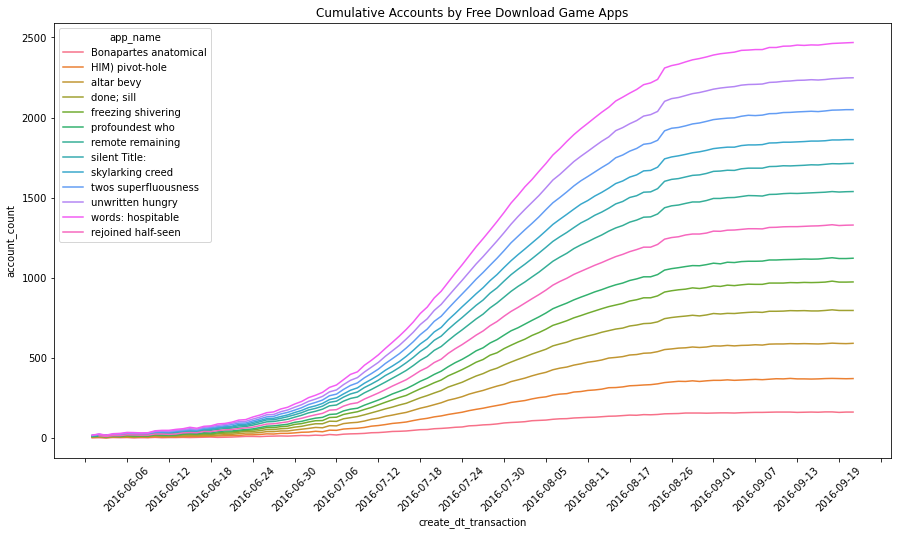

In [68]:
# cumulative sum of account_ids by app_name
df_wide_sub5 = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'acct_id']]\
.groupby(by=['create_dt_transaction', 'app_name']).nunique()\
.groupby(level=0).cumsum().reset_index()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='acct_id', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('account_count')
ax.set_title('Cumulative Accounts by Free Download Game Apps')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

### Paid Game Apps

In [ ]:
game_app_prices = df_wide[(df_wide['price'] > 0) & (df_wide['category_name'] == 'Games')][['app_name','price']]\
.groupby(by=['app_name'], as_index=False).sum().sort_values(by='price')

In [73]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][-5:]))][['app_name','acct_id']]\
.groupby(by=['app_name']).nunique()

,acct_id
app_name,
'vomited men,10424
AS-IS vagueness,11203
aright Davy,13817
ceases half;,13585
unwritten hungry,14889


In [74]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][-5:]))][['app_name','price']]\
.groupby(by=['app_name']).sum()

,price
app_name,
'vomited men,322774.99
AS-IS vagueness,323364.79
aright Davy,525507.19
ceases half;,345262.54
unwritten hungry,505983.68


In [82]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][-5:]))][['app_name','type','acct_id']]\
.groupby(by=['app_name','type']).nunique()

acct_id
app_name         type                  
'vomited men     consumable       10424
AS-IS vagueness  consumable       11203
aright Davy      consumable       13817
ceases half;     consumable       13585
unwritten hungry consumable       14554
                 download_only    10712

In [83]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][-5:]))][['app_name','type', 'price']]\
.groupby(by=['app_name','type']).sum()

price
app_name         type                    
'vomited men     consumable     322774.99
AS-IS vagueness  consumable     323364.79
aright Davy      consumable     525507.19
ceases half;     consumable     345262.54
unwritten hungry consumable     505983.68
                 download_only       0.00

In [84]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][:5]))][['app_name','type', 'price']]\
.groupby(by=['app_name','type']).sum()

price
app_name               type                 
Mediterranean mightest download_only  924.66
SAILOR known           consumable     741.51
eventually skies       download_only  920.70
freezing shivering     consumable     708.84
                       download_only    0.00
fully contradictory    download_only  923.67

In [ ]:
df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][:5]))][['app_name','type', 'price']]\
.groupby(by=['app_name','type']).sum()

In [53]:
game_app_prices = df_wide[(df_wide['price'] > 0) & (df_wide['category_name'] == 'Games')][['app_name','price']]\
.groupby(by=['app_name'], as_index=False).sum().sort_values(by='price')

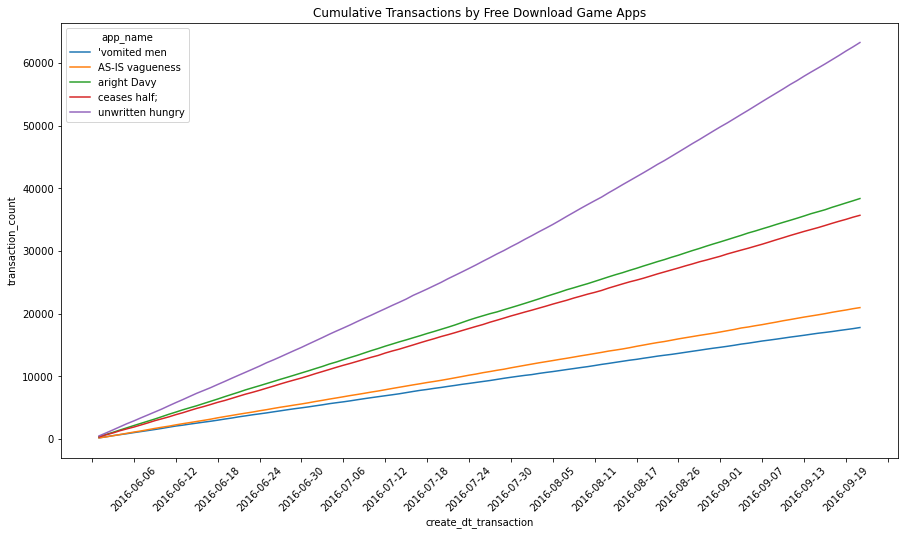

In [72]:
# cumulative sum of transactions by app_name
df_wide_sub5 = df_wide[(df_wide['app_name'].isin(game_app_prices['app_name'][-5:])) & 
                       (df_wide['payment_type'] == 'PMOF')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'acct_id']]\
.groupby(by=['create_dt_transaction', 'app_name']).nunique()\
.groupby(level=1).cumsum().reset_index()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='acct_id', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.set_title('Cumulative Transactions by Free Download Game Apps')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

In [61]:
df_wide_sub5

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment2_category
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,iPad,3/1/09,PMOF,unwritten hungry,consumable,Games,PMOF:Games
20,2016-07-25,4d34d5a904ed7546,0e07ee212be91830,10.99,1,iPhone,3/6/08,PMOF,ceases half;,consumable,Games,PMOF:Games
40,2016-08-18,ae6106b493bcd877,401557401a26a9f5,22.99,1,iPhone,4/24/12,PMOF,AS-IS vagueness,consumable,Games,PMOF:Games
115,2016-06-25,a2f25821c50c6be0,4bafe24ef28c6a85,1.99,2,iPad,2/19/09,PMOF,unwritten hungry,consumable,Games,PMOF:Games
116,2016-07-12,3f01521f917471b1,d4e75b92457f7998,9.99,2,iPad,2/9/11,PMOF,unwritten hungry,consumable,Games,PMOF:Games
...,...,...,...,...,...,...,...,...,...,...,...,...
3607496,2016-08-17,dc5d199e189dff84,ad27fc61c133814b,3.99,2,iPad,9/4/10,PMOF,unwritten hungry,consumable,Games,PMOF:Games
3607500,2016-09-05,141a1700e59744b8,c125062b1364a66e,4.99,2,iPad,4/22/08,PMOF,unwritten hungry,consumable,Games,PMOF:Games
3607502,2016-06-27,96a076a66b214fb7,dd10193e4a67d1aa,29.99,1,iPhone,5/18/12,PMOF,aright Davy,consumable,Games,PMOF:Games
3607506,2016-06-28,26aebfbbaec60a96,402001eac02d9f8a,6.99,2,iPad,2/8/12,PMOF,unwritten hungry,consumable,Games,PMOF:Games


In [63]:
df_wide_sub5[['create_dt_transaction', 'app_name', 'price']]\
.groupby(by=['create_dt_transaction', 'app_name']).count()

price
create_dt_transaction app_name               
2016-06-01            'vomited men        181
                      AS-IS vagueness     181
                      aright Davy         381
                      ceases half;        330
                      unwritten hungry    499
...                                       ...
2016-09-21            'vomited men        178
                      AS-IS vagueness     176
                      aright Davy         369
                      ceases half;        305
                      unwritten hungry    711

[550 rows x 1 columns]

In [69]:
df_wide_sub5[['create_dt_transaction', 'app_name', 'acct_id']]\
.groupby(by=['create_dt_transaction', 'app_name']).nunique()\
.groupby(level=1).cumsum().reset_index()

,create_dt_transaction,app_name,acct_id
0,2016-06-01,Bonapartes anatomical,2
1,2016-06-01,HIM) pivot-hole,1
2,2016-06-01,altar bevy,3
3,2016-06-01,done; sill,2
4,2016-06-01,freezing shivering,1
...,...,...,...
1420,2016-09-21,silent Title:,9469
1421,2016-09-21,skylarking creed,8064
1422,2016-09-21,twos superfluousness,10129
1423,2016-09-21,unwritten hungry,10707


### Free Game Apps

In [89]:
game_app_free = df_wide[(df_wide['price'] == 0) & 
        (df_wide['category_name'] == 'Games') &
        (df_wide['payment_type'] == 'Free only')][['app_name','content_id']]\
.groupby(by=['app_name'], as_index=False).count().sort_values(by='content_id')

In [95]:
df_wide[(df_wide['app_name'].isin(game_app_free['app_name'][:5]))][['app_name','payment_type','type','acct_id']]\
.groupby(by=['app_name','payment_type', 'type']).nunique()

acct_id
app_name         payment_type type                  
circulates Anno  Free only    download_only     4275
                 unknown      download_only        6
employed direct  Free only    download_only     4255
                 unknown      download_only        4
lesson; sigh     Free only    download_only     4287
                 unknown      download_only        4
name robust      Free only    download_only     4321
                 unknown      download_only        4
twelvemonth cod; Free only    download_only     4291
                 unknown      download_only        5

In [94]:
df_wide[['acct_id', 'payment_type']].groupby(by=['payment_type']).nunique()

,acct_id
payment_type,
Free only,14993
PMOF,14982
unknown,25


In [96]:
df_wide[df_wide['app_name'] == 'circulates Anno']

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment2_category
1752639,2016-06-06,46037c4ef11b772a,e78d06664cfd2929,0.0,2,iPad,8/26/14,Free only,circulates Anno,download_only,Games,Free only:Games
1752666,2016-08-07,46037c4ef11b772a,77ec46c3171f05dd,0.0,1,iPhone,11/21/13,Free only,circulates Anno,download_only,Games,Free only:Games
1752906,2016-07-26,46037c4ef11b772a,915060ee76a70877,0.0,1,iPhone,2/14/15,Free only,circulates Anno,download_only,Games,Free only:Games
1752918,2016-06-14,46037c4ef11b772a,9370e1182a18d4fa,0.0,1,iPhone,10/27/13,Free only,circulates Anno,download_only,Games,Free only:Games
1753311,2016-07-29,46037c4ef11b772a,6fe6a068bb7ea7bf,0.0,1,iPhone,3/19/16,Free only,circulates Anno,download_only,Games,Free only:Games
...,...,...,...,...,...,...,...,...,...,...,...,...
2919874,2016-08-15,46037c4ef11b772a,1586511d9d72f2a3,0.0,1,iPhone,11/23/16,Free only,circulates Anno,download_only,Games,Free only:Games
2919989,2016-06-22,46037c4ef11b772a,3b443f1f7ade1e1e,0.0,1,iPhone,10/26/13,Free only,circulates Anno,download_only,Games,Free only:Games
2920615,2016-08-10,46037c4ef11b772a,27d36a09fd5426d3,0.0,1,iPhone,3/16/15,Free only,circulates Anno,download_only,Games,Free only:Games
2920762,2016-08-06,46037c4ef11b772a,10f7ca343ebeeb9f,0.0,1,iPhone,3/10/14,Free only,circulates Anno,download_only,Games,Free only:Games


In [97]:
df_wide[(df_wide['acct_id'] == 'e78d06664cfd2929')].sort_values(by='create_dt_transaction')

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment2_category
2276791,2016-06-01,7d3cf8d98c978872,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,Readable marvellous,download_only,Games,Free only:Games
2121575,2016-06-04,a28650fb68fb9806,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,fortress bed-side,download_only,Photos & Videos,Free only:Photos & Videos
1752639,2016-06-06,46037c4ef11b772a,e78d06664cfd2929,0.0,2,iPad,8/26/14,Free only,circulates Anno,download_only,Games,Free only:Games
2410141,2016-06-06,f7f4b2ca2f2108af,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,soul; stultifying,download_only,Photos & Videos,Free only:Photos & Videos
2585263,2016-06-07,27959fb27ce15aa7,e78d06664cfd2929,0.0,2,iPad,8/26/14,Free only,hammer fierceness,download_only,Photos & Videos,Free only:Photos & Videos
1872913,2016-06-07,3bde03960ffaebd7,e78d06664cfd2929,0.0,2,iPad,8/26/14,Free only,saith Kingdom,download_only,Games,Free only:Games
2824828,2016-06-08,4c604d57f0425d9e,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,snaky things--beds,download_only,Photos & Videos,Free only:Photos & Videos
1975977,2016-06-09,93e813a67568bfd8,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,arises LETTER,download_only,Games,Free only:Games
1784996,2016-06-10,2b6d8d91d066497b,e78d06664cfd2929,0.0,1,iPhone,8/26/14,Free only,ranks watches,download_only,Games,Free only:Games
2303613,2016-06-12,641c23bc07b4683d,e78d06664cfd2929,0.0,2,iPad,8/26/14,Free only,equalled Maelstrom,download_only,Utilities,Free only:Utilities
